Jako projekt na przedmiot Analiza i wizualizacja danych zdecydowaliśmy się na analizę zbioru danych gier z platformy Steam. 

Zadaniem projektu jest poznanie preferencji graczy odnośnie gier, najchętniej granych gatunków oraz odpowiedzieć na pytania:
Jakie są najpopularniejsze gry na Steam?
Jakie gry i gatunki mają największą sprzedaż?
Jakie są najdroższe gry i jaki jest udział darmowych gier w rynku?

Na początku załadujemy potrzebne biblioteki:

In [35]:

#%pip install pandas wordcloud matplotlib plotly scikit-learn --upgrade nbformat
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LinearRegression

Oraz plik ze zbiorem danych z Kaggle'a:

In [36]:
current_dir = os.path.dirname(os.path.abspath(''))

first_file = os.path.join(current_dir, 'E:\Game_Analysis\input\games.json')

with open(first_file, 'r', encoding="utf8") as file:
    json_data = json.load(file)

<>:3: SyntaxWarning: invalid escape sequence '\G'
<>:3: SyntaxWarning: invalid escape sequence '\G'
C:\Users\krystian\AppData\Local\Temp\ipykernel_56748\2913553771.py:3: SyntaxWarning: invalid escape sequence '\G'
  first_file = os.path.join(current_dir, 'E:\Game_Analysis\input\games.json')


Konwertujemy zczytane dane z jsona do DataFrame i pozbywamy się niepotrzebnych kolumn:

In [37]:
unnecessary_vars = [
    'packages', 'screenshots', 'movies', 'score_rank', 'header_image',
    'reviews', 'website', 'support_url', 'notes', 'support_email',
    'recommendations', 'median_playtime_2weeks', 'required_age', 'metacritic_score',
    'metacritic_url'
]

In [38]:
# Każda z informacji  o grach jest przekazywana w liście, która następnie służy do powstania DataFrame'a
games = [{
    **{k: v for k, v in game_info.items() if k not in unnecessary_vars},
    'tags': ', '.join(game_info.get('tags', {}).keys()) if isinstance(game_info.get('tags', {}), dict) else '',
    'app_id': app_id
} for app_id, game_info in json_data.items()]

# Stworzenie data frame'u
df = pd.DataFrame(games)

## Data structure

Sprawdźmy pierwsze i ostatnie wiersze zbioru danych:

In [39]:
df.head(5)

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
0,Galactic Bowling,"Oct 21, 2008",19.99,0,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,True,False,False,...,6,11,0 - 20000,0,0,0,0,"Indie, Casual, Sports, Bowling",20200,NaN
1,Train Bandit,"Oct 12, 2017",0.99,0,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,True,True,False,...,53,5,0 - 20000,0,0,0,0,"Indie, Action, Pixel Graphics, 2D, Retro, Arca...",655370,NaN
2,Jolt Project,"Nov 17, 2021",4.99,0,Jolt Project: The army now has a new robotics ...,Jolt Project: The army now has a new robotics ...,"Shoot vehicles, blow enemies with a special at...",True,False,False,...,0,0,0 - 20000,0,0,0,0,,1732930,NaN
3,Henosis™,"Jul 23, 2020",5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,True,True,True,...,3,0,0 - 20000,0,0,0,0,"2D Platformer, Atmospheric, Surreal, Mystery, ...",1355720,NaN
4,Two Weeks in Painland,"Feb 3, 2020",0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,ABOUT THE GAME Play as a hacker who has arrang...,Two Weeks in Painland is a story-driven game a...,True,True,False,...,50,8,0 - 20000,0,0,0,0,"Indie, Adventure, Nudity, Violent, Sexual Cont...",1139950,NaN


In [40]:
df.tail(5)

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
111447,Paragon Of Time,"Apr 10, 2025",2.99,0,"You stand at the edge of time, trying to save ...","You stand at the edge of time, trying to save ...",Crush the darkness that is corrupting time its...,True,False,False,...,5,0,0 - 20000,0,0,0,0,"Action Roguelike, Bullet Hell, Hack and Slash,...",3600970,0
111448,A Few Days With : Hazel,"Apr 11, 2025",2.69,0,"Join Hazel, an attractive young lady, and enjo...","Join Hazel, an attractive young lady, and enjo...",Embark on a sensual butterfly-hunting adventur...,True,False,False,...,0,0,0 - 20000,0,0,0,0,,3543710,10
111449,MosGhost,"Apr 1, 2025",7.99,0,Check out ADD TO WISHLIST About the Game Story...,Story : Andrei moved to Moscow for work and re...,"Having moved to Moscow, Andrei rents a cheap a...",True,False,False,...,24,12,0 - 20000,0,0,0,0,"Simulation, Walking Simulator, Idler, First-Pe...",3265370,0
111450,AccuBow VR,"Mar 11, 2025",0.00,0,AccuBow VR: Master Realistic Archery in Immers...,AccuBow VR: Master Realistic Archery in Immers...,Take your archery training to the next level a...,True,False,False,...,0,0,0 - 0,0,0,0,0,,3423620,0
111451,Defense Of Fort Burton,"Apr 10, 2025",9.99,0,Face series of battles defending the good peop...,Face series of battles defending the good peop...,The battle awaits—defend your loved ones with ...,True,False,False,...,0,0,0 - 20000,0,0,0,0,,3183790,0


In [41]:
# Liczba kolumn i wierszy
df.shape

(111452, 28)

In [42]:
# Brakujące dane w komórkach
def is_empty(cell):
    if isinstance(cell, list):
        return len(cell) == 0
    elif isinstance(cell, str):
        return cell == ''
    else:
        return pd.isna(cell)
print(df.map(is_empty).sum())

name                            6
release_date                    0
price                           0
dlc_count                       0
detailed_description         6457
about_the_game               6483
short_description            6376
windows                         0
mac                             0
linux                           0
achievements                    0
supported_languages          6434
full_audio_languages        65823
developers                   6471
publishers                   1706
categories                   7566
genres                       6440
user_score                      0
positive                        0
negative                        0
estimated_owners                0
average_playtime_forever        0
average_playtime_2weeks         0
median_playtime_forever         0
peak_ccu                        0
tags                        37423
app_id                          0
discount                    97410
dtype: int64


Niektóre komórki zawierają brakujące dane, ponieważ na steamie są publikowane gry jako testy, które posiadają znikome informacje. W przypadku *full_audio_languages*, pole jest puste jeśli gra nie posiada mówionych dialogów - co w miarę często się pojawia. W przypadku *tags*, to pole definiuje oznakowania wybrane przez graczy, więc dużo niepopularnych gier nie posiada tagów. Pomijajac wcześniej wspomniane języki audio, wiersze z brakującymi wartościami zostaną usunięte.

## Individual variables

Sprawdźmy zmienne w zbiorze. **app_id** jest identyfikatorem każdej gry i pozwala sprawdzić czy nie ma duplikatów:

In [43]:
df['app_id'].duplicated().sum()

0

In [44]:
# Konwertujemy release_date to formatu daty
df['release_date'] = pd.to_datetime(df['release_date'], format='mixed')

In [45]:
# Znajdujemy grę z najwcześniejszą datą premiery
df['release_date'].min()

Timestamp('1997-06-30 00:00:00')

In [46]:
# Gra z najdalszą datą premiery według zbioru danych
df['release_date'].max()

Timestamp('2025-05-30 00:00:00')

Sprawdźmy top 5 najpopularniejszych gier na Steamie

In [47]:
def extract_lower_bound(range_str):
    return int(range_str.split('-')[0].strip())

# Dodaj kolumnę pomocniczą z dolną granicą widełek
df_sorted = df.assign(lower_bound=df['estimated_owners'].map(extract_lower_bound))

# Sortuj malejąco po dolnej granicy
df_sorted = df_sorted.sort_values(by='lower_bound', ascending=False)

# Wybierz tylko kolumny estimated_owners oraz name
result_df = df_sorted[['estimated_owners', 'name']]

print(result_df.head())

            estimated_owners                              name
17585  100000000 - 200000000                            Dota 2
7030    50000000 - 100000000                         New World
96948   50000000 - 100000000                Black Myth: Wukong
8885    50000000 - 100000000               PUBG: BATTLEGROUNDS
46158   50000000 - 100000000  Counter-Strike: Global Offensive


In [48]:
# Niewydane jeszcze gry
from datetime import datetime

df['release_date'] = pd.to_datetime(df['release_date'], format='%b %d, %Y', errors='coerce')
df[df['release_date'] > datetime.today().strftime('%Y-%m-%d')]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount


Obecnie wszystkie gry z danego zbioru danych, które miały wyjść w 2025 już się pojawiły, dlatego zbiór wyżej jest pusty.

In [49]:
df = df[df['release_date'] != 2025]

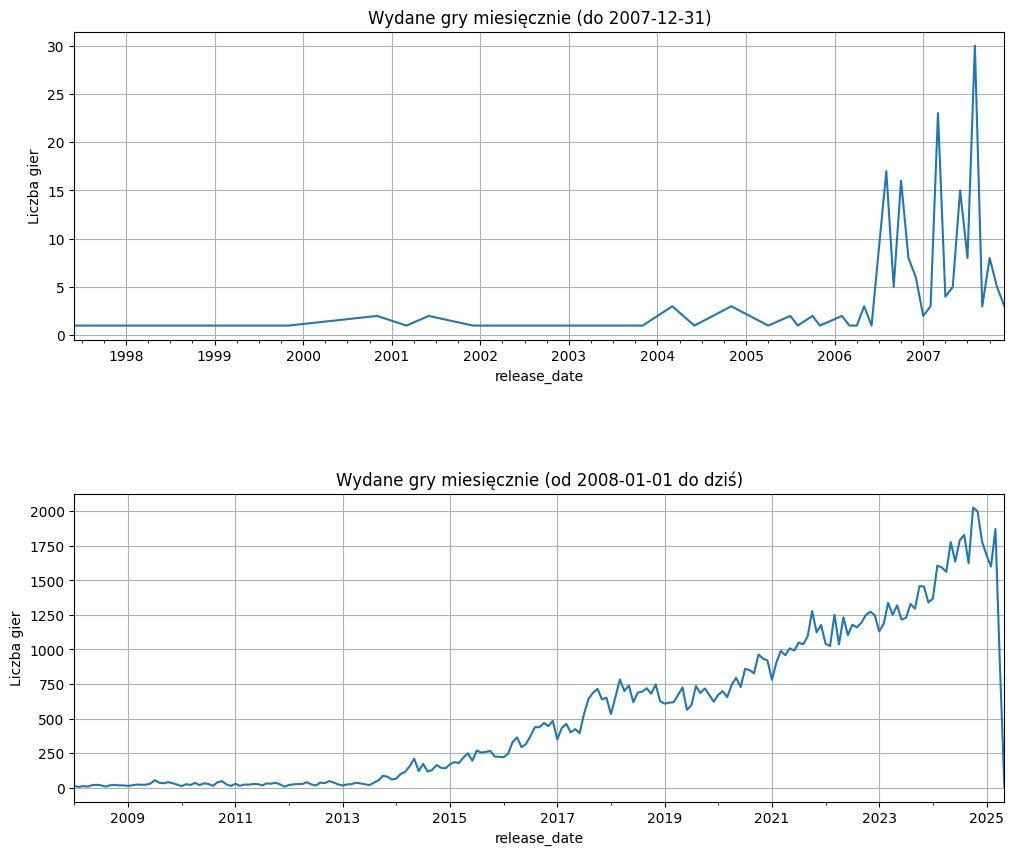

In [50]:

cutoff_date = pd.to_datetime('2007-12-31')
df_before = df[df['release_date'] <= cutoff_date]
df_after = df[df['release_date'] > cutoff_date]


before_monthly = df_before.groupby(df_before['release_date'].dt.to_period('M')).size()
after_monthly = df_after.groupby(df_after['release_date'].dt.to_period('M')).size()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)


before_monthly.plot(kind='line', ax=ax1)
ax1.set_title('Wydane gry miesięcznie (do 2007-12-31)')
ax1.set_ylabel('Liczba gier')
ax1.grid(True)

after_monthly.plot(kind='line', ax=ax2)
ax2.set_title('Wydane gry miesięcznie (od 2008-01-01 do dziś)')
ax2.set_ylabel('Liczba gier')
ax2.grid(True)

plt.show()

Jak można zauważyć na wykresie, liczba gier publikowanych miesięcznie rośnie z czasem. Do 2007 liczba miesięcznie gier ledwo przekraczała 30 pozycji. Widać, na drugim wykresie, że około 2013 roku nastąpił wzrost i miesięcznie były to już setki. Jest to spowodowane oczywiście z coraz większą liczbą gier wydawanych na platformie, ale również z (w mniejszym stopniu) usuwanymi grami ze sklepu, co widać po spadkach.

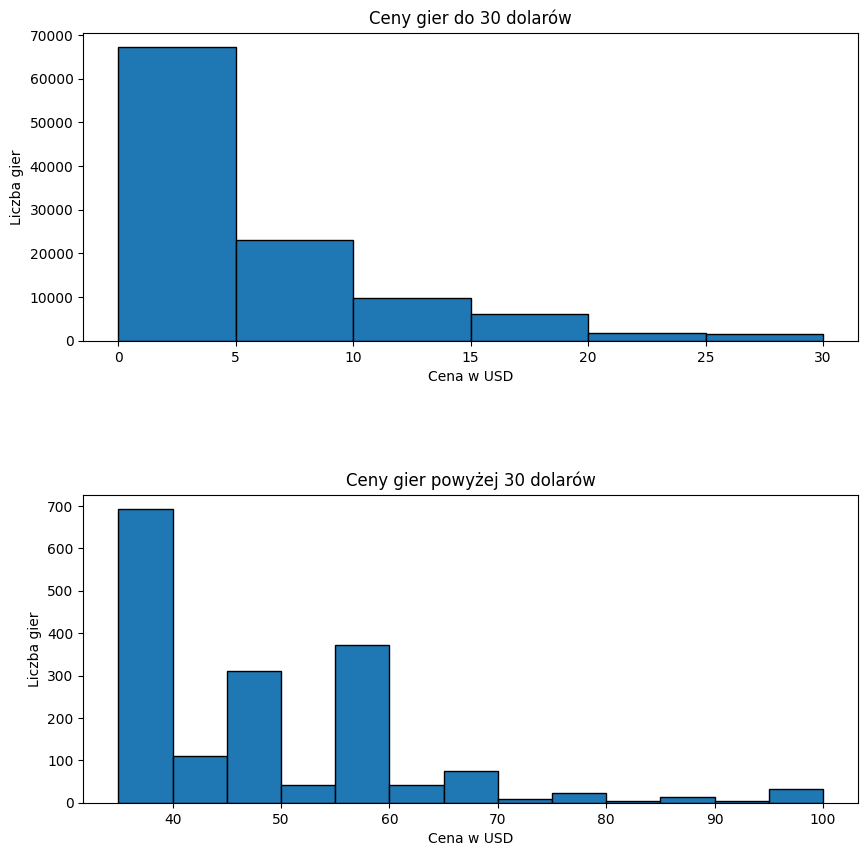

In [51]:
# Prices
price_cutoff = 30

prices_below_30 = df[df['price'] <= price_cutoff]['price']
prices_above_30 = df[df['price'] > price_cutoff]['price']

bins_below = range(0, 35, 5)  # do 60 dolarów, co 5 dolarów
bins_above = range(35, 105, 5)  # powyżej 60 dolarów, co 5 dolarów

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

ax1.hist(prices_below_30, bins=bins_below, edgecolor='black')
ax1.set_title('Ceny gier do 30 dolarów')
ax1.set_xlabel('Cena w USD')
ax1.set_ylabel('Liczba gier')

ax2.hist(prices_above_30, bins=bins_above, edgecolor='black')
ax2.set_title('Ceny gier powyżej 30 dolarów')
ax2.set_xlabel('Cena w USD')
ax2.set_ylabel('Liczba gier')

plt.show()

W dystrybucji cen gier, można zauważyć, że większość gier na steamie jest albo za darmo, albo z niską ceną. Znakomita większość gier znajduje się w przedziale 0-5 dolarów. Jednakże znajdują się również gry powyżej $60.

In [52]:
# Procent darmowych gier
round(df[df['price'] == 0].shape[0] / df.shape[0], 2)

0.21

Z wyniku powyżej wychodzi, że 21% gier na steamie jest za darmo. 

In [53]:
# Najwyższa cena produkcji na steamie
df['price'].max()

999.98

Najwyższą ceną na steamie jest produkcja za prawie tysiąc dolarów. Sprawdźmy jaka to produkcja

In [54]:
# Szukamy najdroższej gry na Steamie
df[df['price'] > 900]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
26936,Ascent Free-Roaming VR Experience,2019-12-27,999.00,0,The Ascent is a Free-Roaming highly immersive ...,The Ascent is a Free-Roaming highly immersive ...,A premium highly-immersive VR experience devel...,True,False,False,...,6,0,0 - 20000,0,0,0,0,"Action, VR, Free to Play, Multiplayer, Arena S...",1200520,NaN
81901,The Leverage Game,2023-08-25,999.98,0,The Leverage Game is a board game in which pla...,The Leverage Game is a board game in which pla...,"You can learn realistic, world-class managemen...",True,False,False,...,0,0,0 - 20000,0,0,0,0,,2499620,NaN
82971,The Leverage Game Business Edition,2023-08-26,999.98,0,The Leverage Game is a board game in which pla...,The Leverage Game is a board game in which pla...,"You can learn realistic, world-class managemen...",True,False,False,...,0,0,0 - 20000,0,0,0,0,,2504210,NaN


Za cenę 998.98 dostaniemy grę *The Leverage Game*.

In [55]:
# Gry powyżej 100 dolarów
df[df['price'] > 100]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
1134,灰烬行星与填鸭少女,2020-08-08,199.99,0,高价的意思是这游戏停售；但挂在架上好看 ===Story=== 在河北省，核大战后孤独的世界...,高价的意思是这游戏停售；但挂在架上好看 ===Story=== 在河北省，核大战后孤独的世界...,在河北省，核大战后孤独的世界末日，机器人守卫在尘封的考场。 长久的等待之后，全国最后一名考生...,True,False,False,...,6,1,0 - 20000,0,0,0,0,"Casual, Adventure, Visual Novel, Interactive F...",1340860,NaN
2038,Earthquake escape,2021-11-25,199.99,0,"This is an earthquake escape game, about how t...","This is an earthquake escape game, about how t...","This is an earthquake escape game, about how t...",True,False,False,...,1,1,0 - 20000,0,0,0,0,"Simulation, Education, 3D, Tutorial, Singleplayer",1720060,NaN
3258,安全教育,2018-06-03,199.99,0,"Through the series of Colyu safety education, ...","Through the series of Colyu safety education, ...","Through the series of Colyu safety education, ...",True,False,False,...,0,0,0 - 20000,0,0,0,0,,865150,NaN
6763,Substance 3D Painter 2022,2021-11-24,149.99,0,Adobe Substance 3D Painter is the reference te...,Adobe Substance 3D Painter is the reference te...,Adobe Substance 3D Painter is the reference te...,True,True,True,...,266,18,0 - 20000,0,0,0,150,"Game Development, Animation & Modeling",1775390,NaN
6970,Tumble,2021-12-15,199.99,0,YOU ARE THE ONLY HOPE Tumble is an action-plat...,YOU ARE THE ONLY HOPE Tumble is an action-plat...,Tumble is a 2D indie action-platformer set in ...,True,False,False,...,9,1,0 - 20000,0,0,0,0,"Exploration, 2D Platformer, Action, Dungeon Cr...",1828710,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109698,Archaeology - Grass Farm,2025-03-10,199.99,0,A game of the genre find the hidden object. Us...,A game of the genre find the hidden object. Us...,A game of the genre find the hidden object.,True,False,False,...,1,0,0 - 20000,0,0,0,0,"Action, Adventure, Casual, Racing, RPG, Simula...",3517290,0
110366,Substance 3D Designer 2025,2025-03-11,199.99,0,Adobe Substance 3D Designer is the industry's ...,Adobe Substance 3D Designer is the industry's ...,Adobe Substance 3D Designer is the industry's ...,True,True,True,...,7,1,0 - 20000,0,0,0,15,"Design & Illustration, Animation & Modeling, G...",3366300,0
110557,ROOM FOOTBALL - Wetlands,2025-04-10,119.99,0,"Puzzle, artillery, casual puzzle video game wi...","Puzzle, artillery, casual puzzle video game wi...","Puzzle, artillery, casual puzzle video game wi...",True,True,True,...,0,0,0 - 0,0,0,0,0,,3612760,0
110852,ROOM FOOTBALL - Apocalyptic Wasteland,2025-04-09,119.99,0,"Puzzle, artillery, casual puzzle video game wi...","Puzzle, artillery, casual puzzle video game wi...","Puzzle, artillery, casual puzzle video game wi...",True,True,True,...,0,0,0 - 0,0,0,0,0,,3602120,0


Jeśli chodzi o gry powyżej $100, na steamie takich znajduje się 227 pozycji.

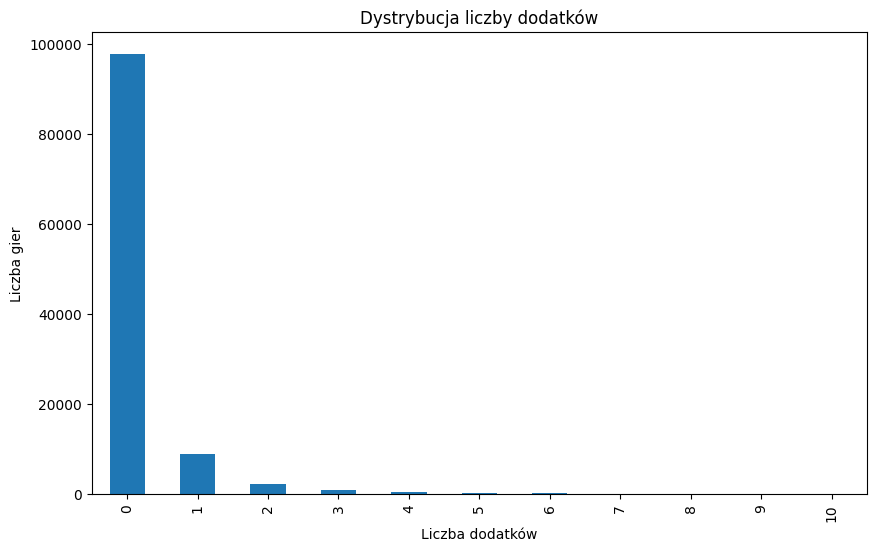

In [56]:
# Liczba dodatków do gier poniżej 10
dlc_counts = df['dlc_count'].value_counts().sort_index()
dlc_counts = dlc_counts[dlc_counts.index <= 10]
plt.figure(figsize=(10, 6))
dlc_counts.plot(kind='bar')
plt.title('Dystrybucja liczby dodatków')
plt.xlabel('Liczba dodatków')
plt.ylabel('Liczba gier')
plt.show()

Pole *dlc_count* zawiera liczbę dodatków (downloadable content - DLC) do każdej gry. Dystrybucja pomiędzy 0 a 10 pokazuje, że większość gier nie zawiera żadnej dodatkowej zawartości. Co jest dobrym znakiem dla graczy.

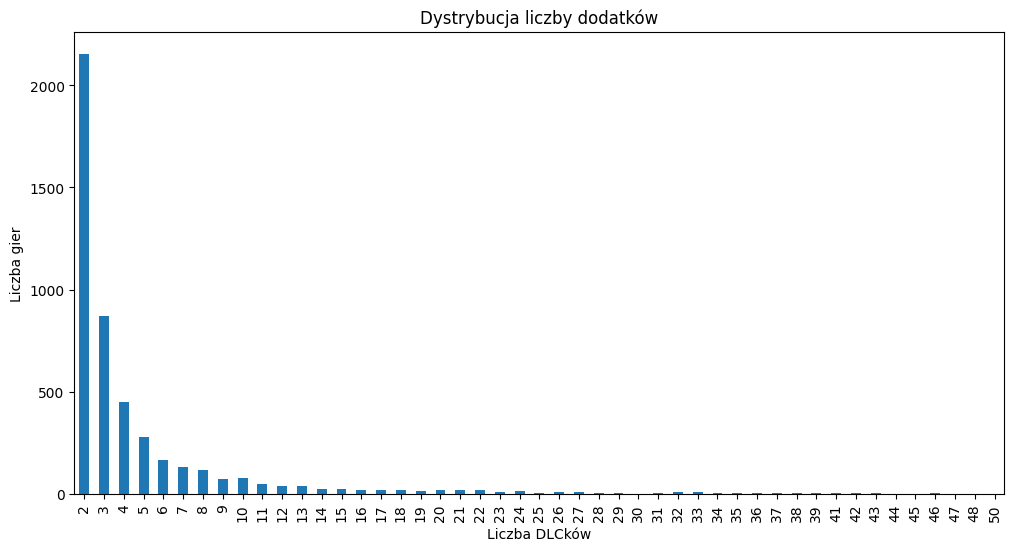

In [57]:
# Dystrybucja dodatków dla gier (2 do 50)
dlc_counts = df['dlc_count'].value_counts().sort_index()
dlc_counts = dlc_counts[(dlc_counts.index >= 2) & (dlc_counts.index <= 50)]
plt.figure(figsize=(12, 6))
dlc_counts.plot(kind='bar')
plt.title('Dystrybucja liczby dodatków')
plt.xlabel('Liczba DLCków')
plt.ylabel('Liczba gier')
plt.show()

 Jeśli prześledzimy dystrybucję tylko dla 2+ DLC, możemy zauważyć, że wraz z wzrostem liczby DLC, liczba gier maleje wykładniczo. Gra z największą liczbą dodatków, zawiera ich ile? Sprawdźmy!

In [58]:
# Maksymalna liczba DLC
df['dlc_count'].max()

2366

Jedna produkcja zawiera aż 2366 dodatków! Jaka to może być gra?

In [59]:
df[df['dlc_count'] == 2366]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
32933,Fantasy Grounds Unity,2020-11-05,39.99,2366,Featured DLC / D&amp;D Essentials D&amp;D Adve...,Prep Less. Play Better. Fantasy Grounds is kno...,Prep Less. Play Better. Exciting upgrades awai...,True,True,True,...,424,60,20000 - 50000,789,0,888,145,"RPG, Dungeons & Dragons, Strategy, Indie, Soft...",1196310,NaN


Zwycięzcą w liczbie dodatków jest gra Fantasy Grounds Unity... która sama na początek już kosztuje $40.

Steam posiada 3 sekcje dla opisów gry, które mogą być analizowane przy pomocy chmurek słów. Pierwszym jest krótki opis, drugim jest "o tej grze", a trzecim "szczegółowy opis". 

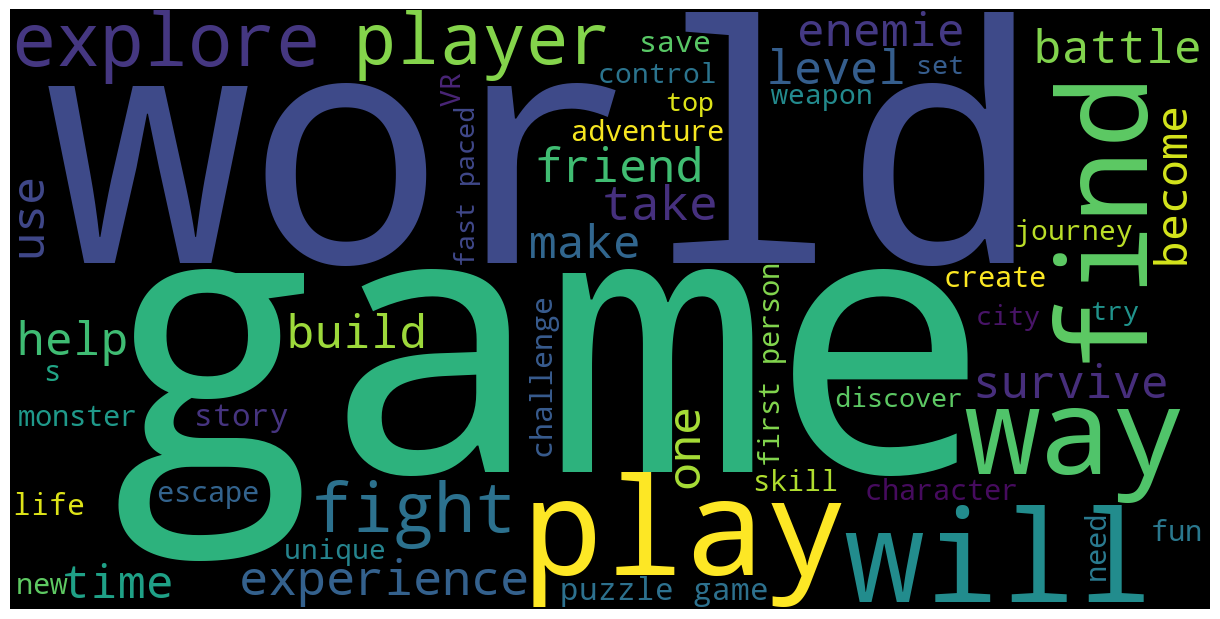

In [60]:
# Wordcloud: short_description
all_descriptions = ','.join(list(df['short_description'].values))
wordcloud = WordCloud(width = 1200, height = 600, max_words=50).generate(all_descriptions)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

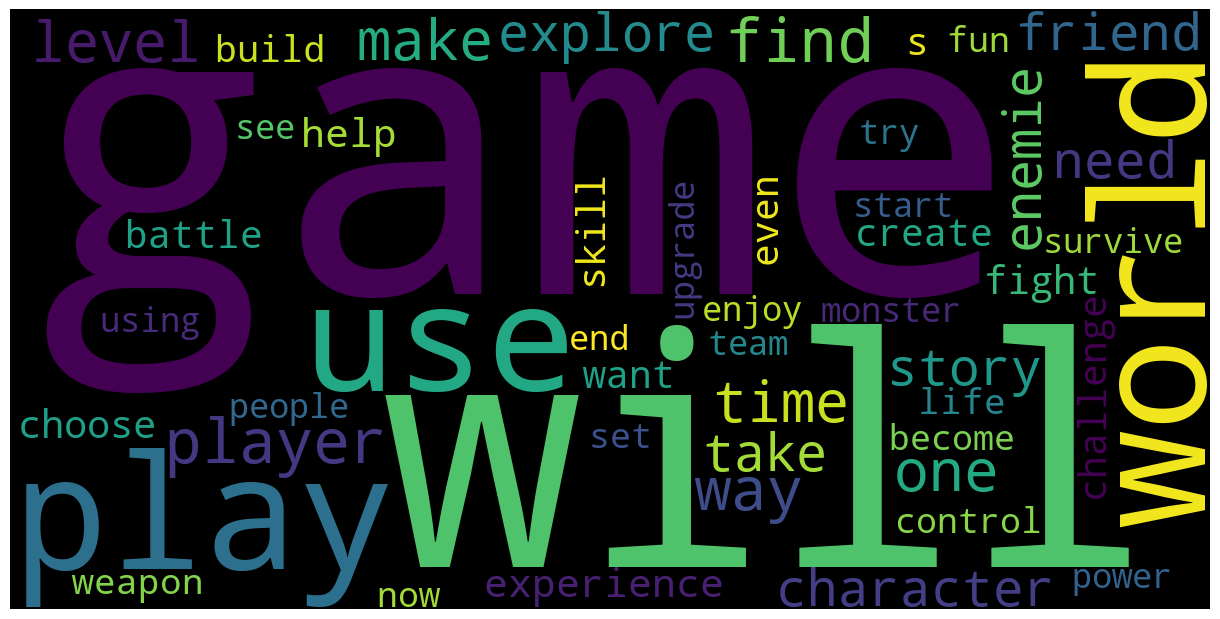

In [61]:
# Wordcloud: about_the_game
all_descriptions = ','.join(list(df['about_the_game'].values))
wordcloud = WordCloud(width = 1200, height = 600, max_words=50).generate(all_descriptions)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

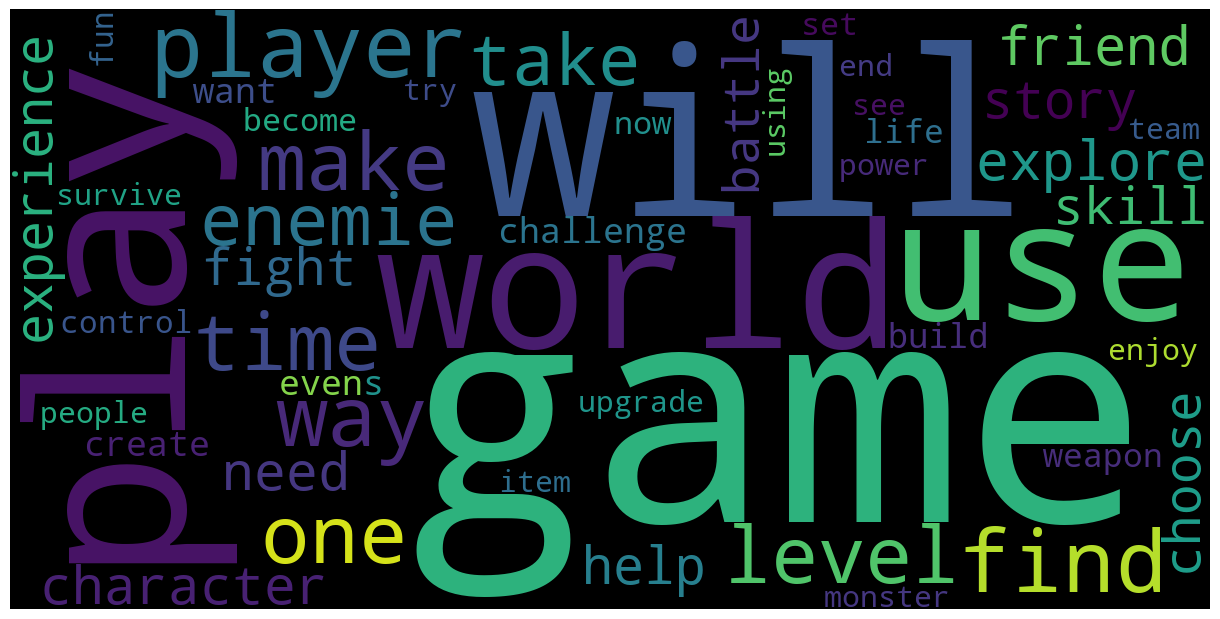

In [62]:
# Wordcloud: detailed_description
all_descriptions = ','.join(list(df['detailed_description'].values))
wordcloud = WordCloud(width = 1200, height = 600, max_words=50).generate(all_descriptions)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Możemy zauważyć, że najbardziej powtarzające się słowa są podobne we wszystkich 3 sekcjach.

Możemy również przeanalizowac proporcję gier dostępnych na 3 systemach: Windows, Max i Linux:

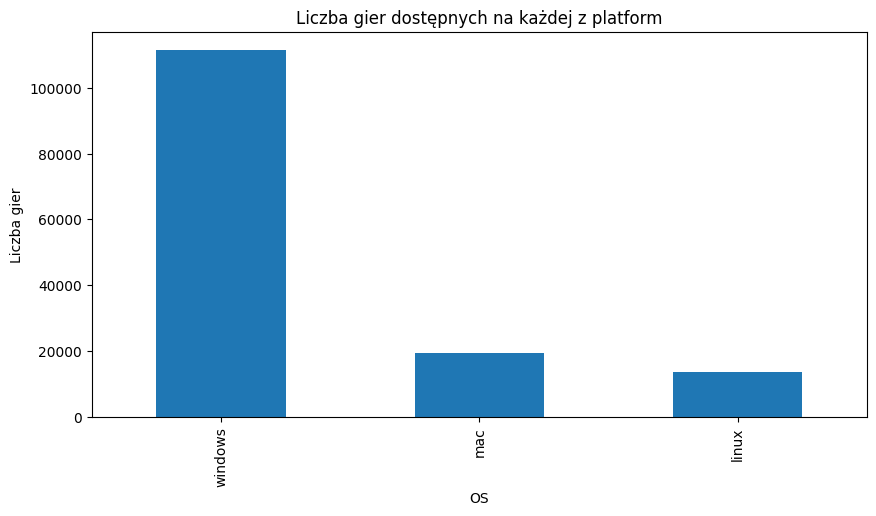

In [63]:
# Wsparcie systemów
platform_sums = df[['windows', 'mac', 'linux']].sum()
plt.figure(figsize=(10, 5))
platform_sums.plot(kind='bar')
plt.title('Liczba gier dostępnych na każdej z platform')
plt.xlabel('OS')
plt.ylabel('Liczba gier')
plt.show()

Ze zdecydowaną przewagą wygrywa tutaj system firmy Microsoft, gdzie praktycznie wszystkie wspierają ten system.

Kolumna *achievements* zawiera wewnątrzgrowe osiągnięcia, wyświetlane na publicznym profilu gracza. 

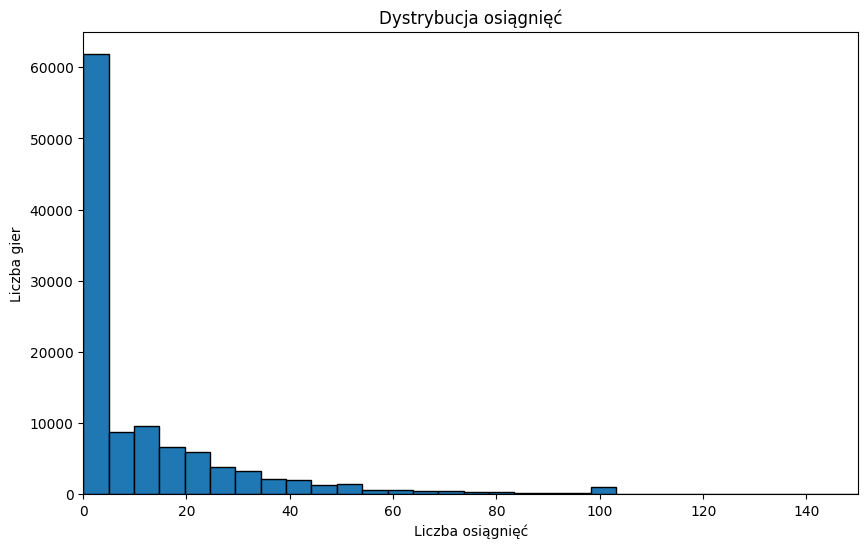

In [64]:
# Achievements (limited to 150)
plt.figure(figsize=(10, 6))
plt.hist(df['achievements'].dropna(), bins=2000, edgecolor='black')
plt.title('Dystrybucja osiągnięć')
plt.xlabel('Liczba osiągnięć')
plt.ylabel('Liczba gier')
plt.xlim(0, 150)
plt.show()

In [65]:
# Proportion of games with 0 achievements
count_of_zero_achievements = (df['achievements'] == 0).sum()
total_rows = len(df)
round(count_of_zero_achievements / total_rows, 2)

0.52

In [66]:
# Maksymalna liczba achievementów grze
df['achievements'].max()

9821

52% gier nie posiada żadnych osiągnięć, a gra z największą ich liczbą, posiada 9821 i jest nią gra LOGistICAL.

In [67]:
df[df['achievements'] == df['achievements'].max()]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
50218,LOGistICAL,2017-02-15,9.99,7,"LOGistICAL is a large open-world, strategy, pu...","LOGistICAL is a large open-world, strategy, pu...",LOGistICAL is a strategy puzzle game where you...,True,False,False,...,174,40,50000 - 100000,0,0,0,12,"Casual, Strategy, Indie, Puzzle, Resource Mana...",573060,NaN


Sprawdźmy teraz informacje o językach tekstowych i dźwiękowych w grach. Język angielski jest oczywiście dominującym językiem.

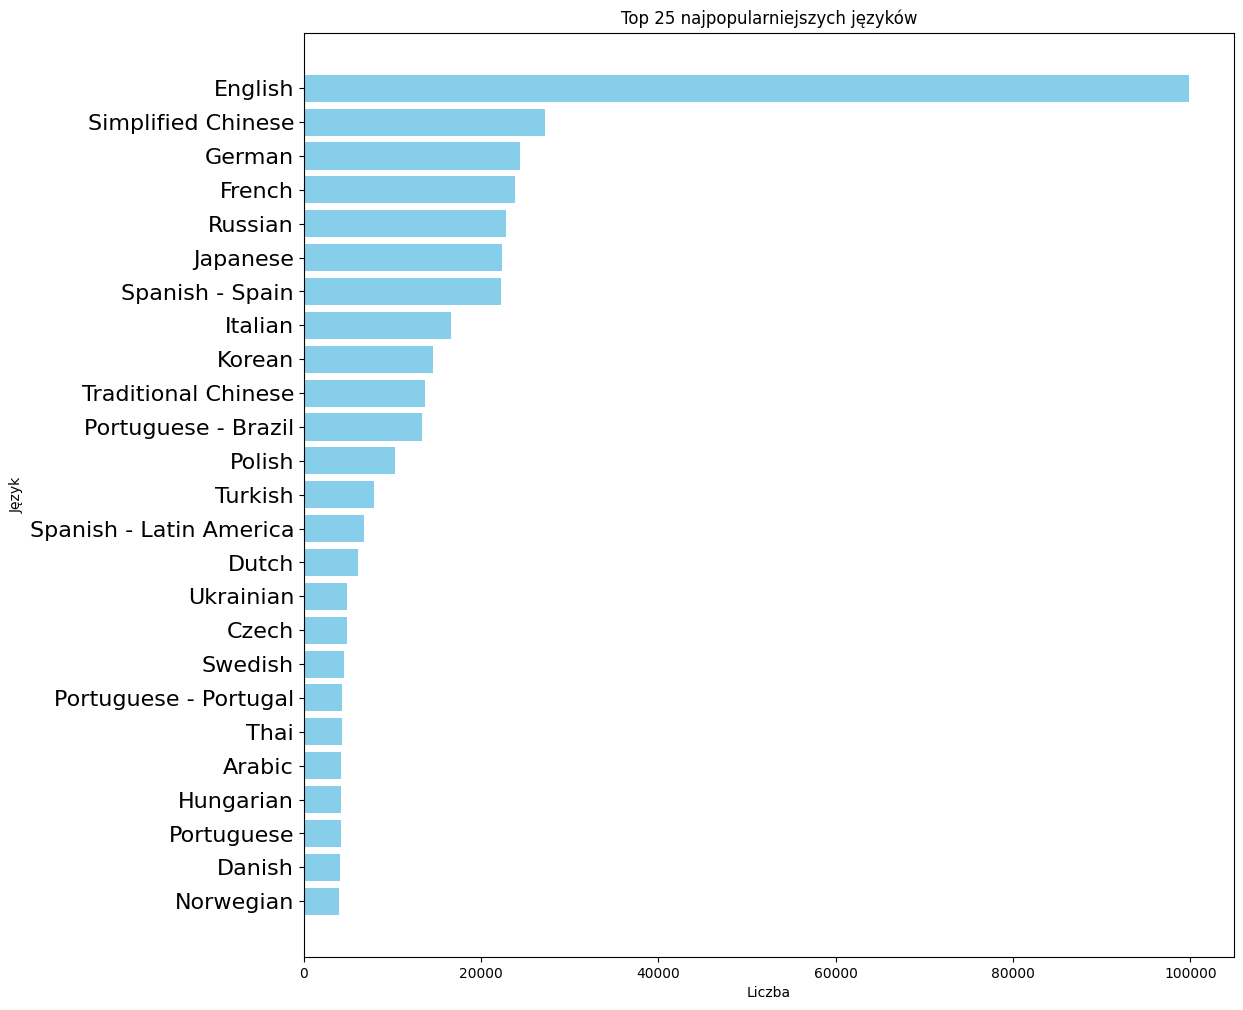

In [68]:
# Języki tekstowe (top 25)
all_languages = [lang for sublist in df['supported_languages'].dropna() for lang in sublist if sublist]
language_counts = Counter(all_languages)
lang_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count']).sort_values('Count', ascending=False)
top_lang_df = lang_df.head(25)
plt.figure(figsize=(12, 12))
plt.barh(top_lang_df['Language'], top_lang_df['Count'], color='skyblue')
plt.title('Top 25 najpopularniejszych języków')
plt.ylabel('Język')
plt.xlabel('Liczba')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

Przeważająca część gier jest w języku angielskim. Warto zwrócić uwagę, że język polski znajduje się w top 25 najpopularniejszych języków wspieranych na steamie.

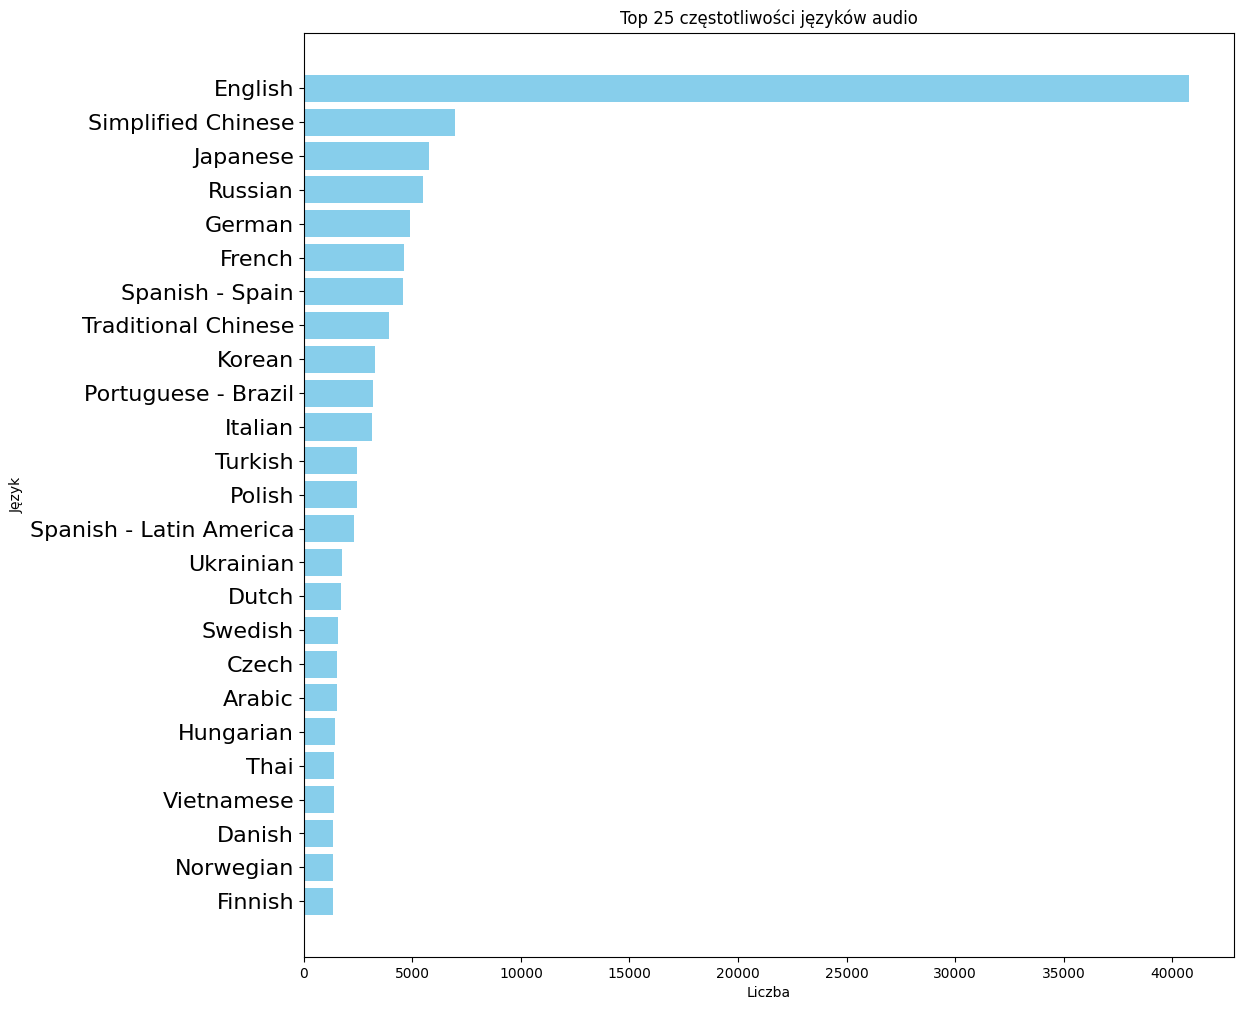

In [69]:
# Języki audio
all_languages = [lang for sublist in df['full_audio_languages'].dropna() for lang in sublist if sublist]
language_counts = Counter(all_languages)
lang_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count']).sort_values('Count', ascending=False)
top_lang_df = lang_df.head(25)
plt.figure(figsize=(12, 12))
plt.barh(top_lang_df['Language'], top_lang_df['Count'], color='skyblue')
plt.title('Top 25 częstotliwości języków audio')
plt.ylabel('Język')
plt.xlabel('Liczba')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

Podobnie jak w językach do tekstów, tak we wsparciu audio w konkretnym języku, najpopularniejszym jest angielski, a polski dalej znajduje się w top 25.

Sprawdźmy dystrybucję gier poprzez deweloperów. Można zauważyć, że w top 10 twórców, większość firm tworzy niszowe (pierwsze miejsce zajmuje firma tworząca mini erotyczne gry, zapewne na zasadzie kopiuj-wklej). Z większych twórców, jest w rankingu japońska firma KOEI TECMO, twórcy m.in. serii Nioh.

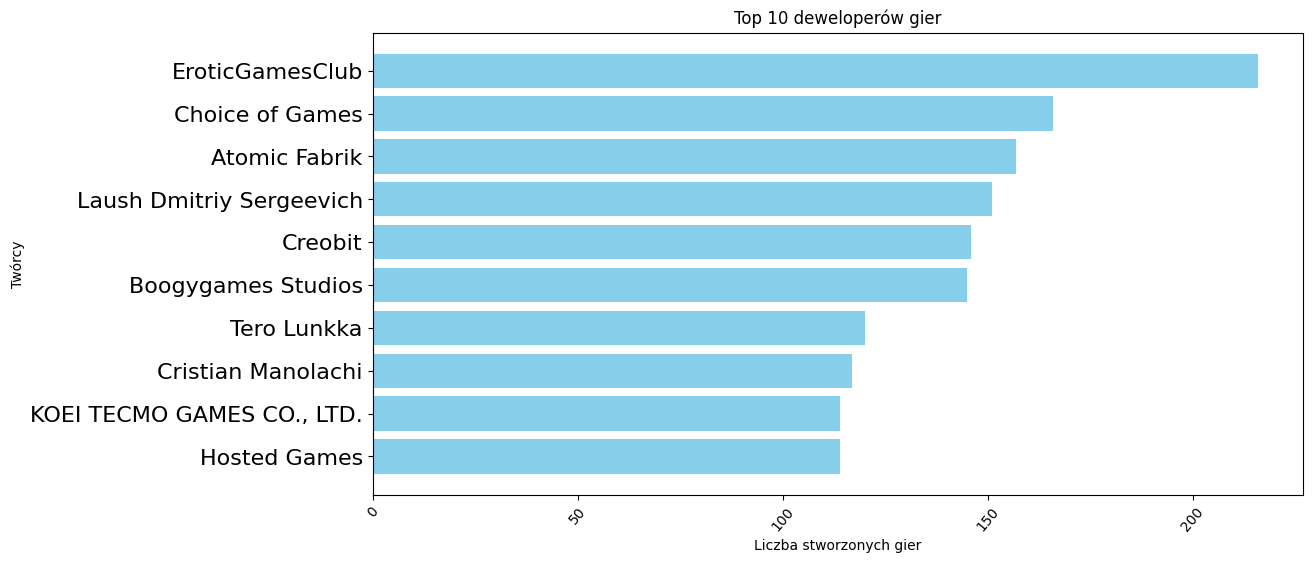

In [70]:
# Deweloperzy (top 10)
all_developers = [dev for sublist in df['developers'].dropna() for dev in sublist if sublist]
developer_counts = Counter(all_developers)
top_developers = pd.DataFrame(developer_counts.most_common(10), columns=['Developer', 'Games Developed'])
plt.figure(figsize=(12, 6))
plt.barh(top_developers['Developer'], top_developers['Games Developed'], color='skyblue')
plt.title('Top 10 deweloperów gier')
plt.ylabel('Twórcy')
plt.xlabel('Liczba stworzonych gier')
plt.xticks(rotation=50)
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

Teraz przyjrzyjmy się wydawcom. Najwięcej wydała gier firma Big Fish Games skupiająca się na mini grach idących bardziej w ilosć, niż jakość. Pomijając ponownie firmę skupiającą się na grach erotycznych, wśród wydawców możemy zauważyć, więcej większych graczy na rynku, takich jak SEGA, Square Enix czy EA. Warto zwrócić uwagę, że na liście znajduje się również polska firma PlayWay.

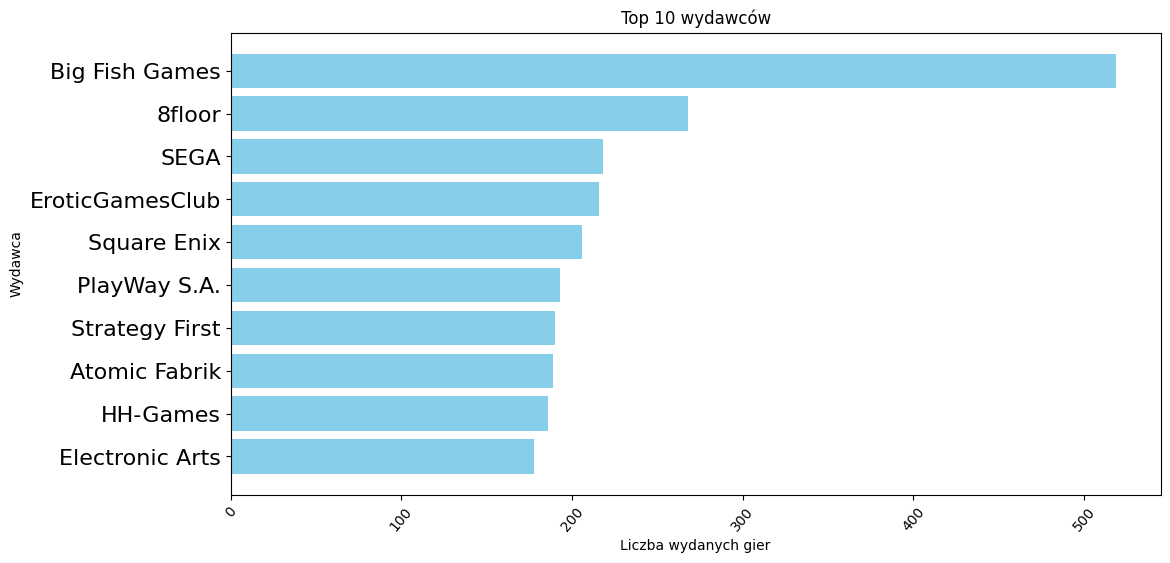

In [71]:
# Wydawcy (top 10)
all_publishers = [pub for sublist in df['publishers'] for pub in sublist if sublist and pub != '']
publisher_counts = Counter(all_publishers)
top_publishers = pd.DataFrame(publisher_counts.most_common(10), columns=['Publisher', 'Games Published'])
plt.figure(figsize=(12, 6))
plt.barh(top_publishers['Publisher'], top_publishers['Games Published'], color='skyblue')
plt.title('Top 10 wydawców')
plt.ylabel('Wydawca')
plt.xlabel('Liczba wydanych gier')
plt.xticks(rotation=50)
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

In [72]:
# Calkowita liczba twórców
all_developers = [dev for sublist in df['developers'].dropna() for dev in sublist]
len(set(all_developers))

68569

In [73]:
# Całkowita liczba wydawców
all_publishers = [dev for sublist in df['publishers'].dropna() for dev in sublist]
len(set(all_publishers))

56995

Liczba twórców nie jest tak różna od liczby wydawców. Może to być związane z tym, że Steam umożliwia samopublikowanie gier na platformie, bez pomocy wydawcy, więc dużo mniejszych studiów korzysta z tej opcji i wydaje grę we własnym zakresie.

Zmienna kategorie zawiera informacje o liczbie możliwych graczy lub składowych elementów gry. Tym samym widzimy, że znacząca ilość gier na Steamie to gry posiadające tryb dla pojedynczego gracza. Jest również dużo gier wspierających kooperację, jednakże ta kategoria jest rozbita na mniej pokroju tylko kooperacja przez internet lub lokalnie, co tworzy od razu inną kategorię.

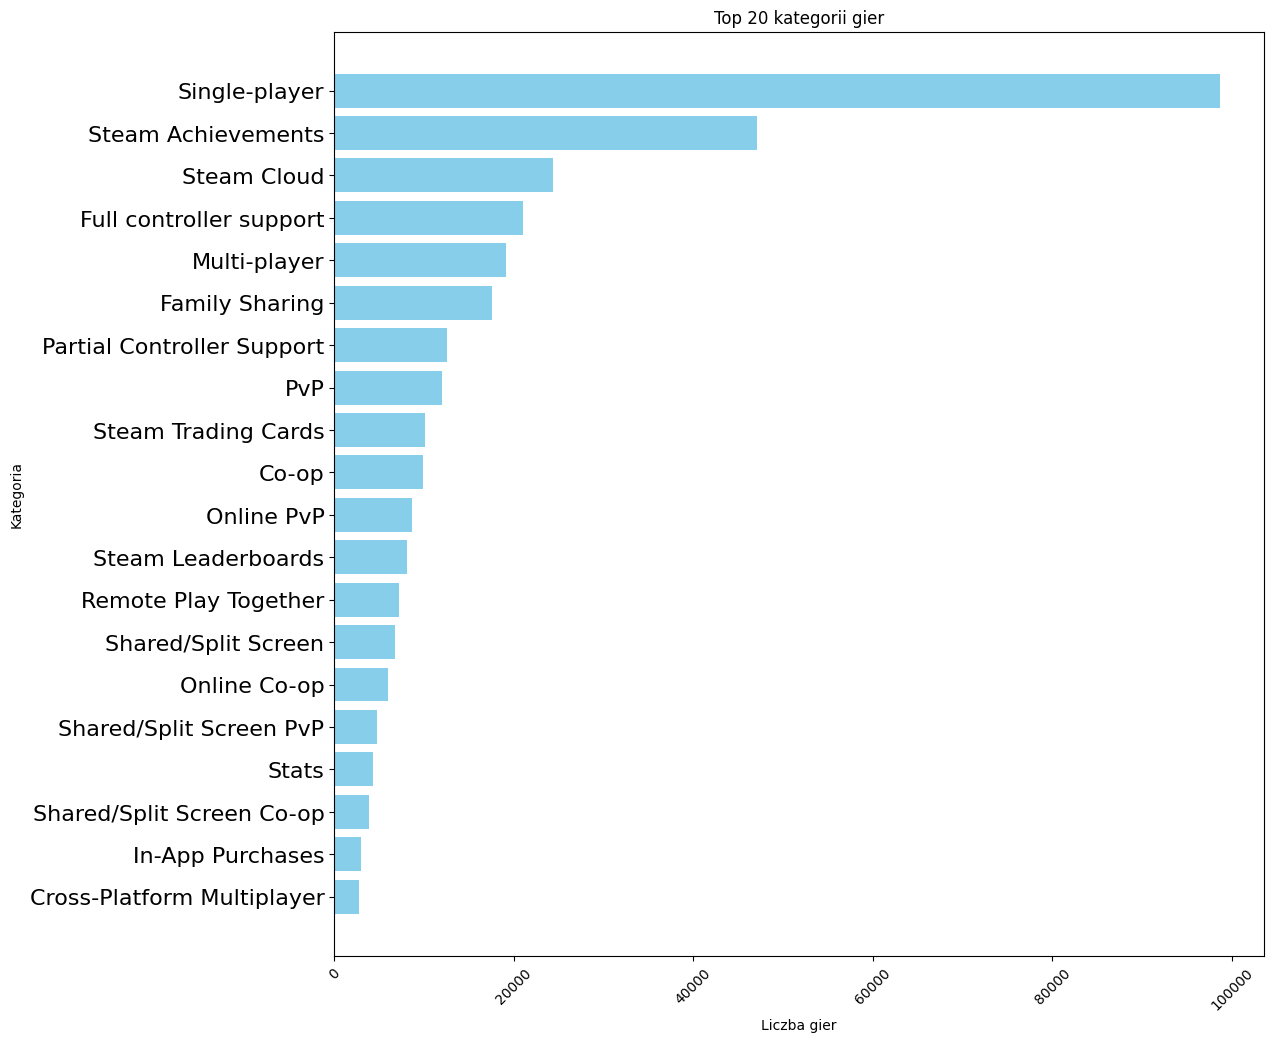

In [74]:
# Categories (top 20)
all_categories = [category for sublist in df['categories'].dropna() for category in sublist if sublist]
category_counts = Counter(all_categories)
top_categories = pd.DataFrame(category_counts.most_common(20), columns=['Category', 'Games'])
plt.figure(figsize=(12, 12))
plt.barh(top_categories['Category'], top_categories['Games'], color='skyblue')
plt.title('Top 20 kategorii gier')
plt.ylabel('Kategoria')
plt.xlabel('Liczba gier')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

*Genres* zawiera gatunki gry, wybrane przez dystrybutora, podczas gdy *tags* zawiera tagi opisujące grę, wybrane przez graczy Steama:

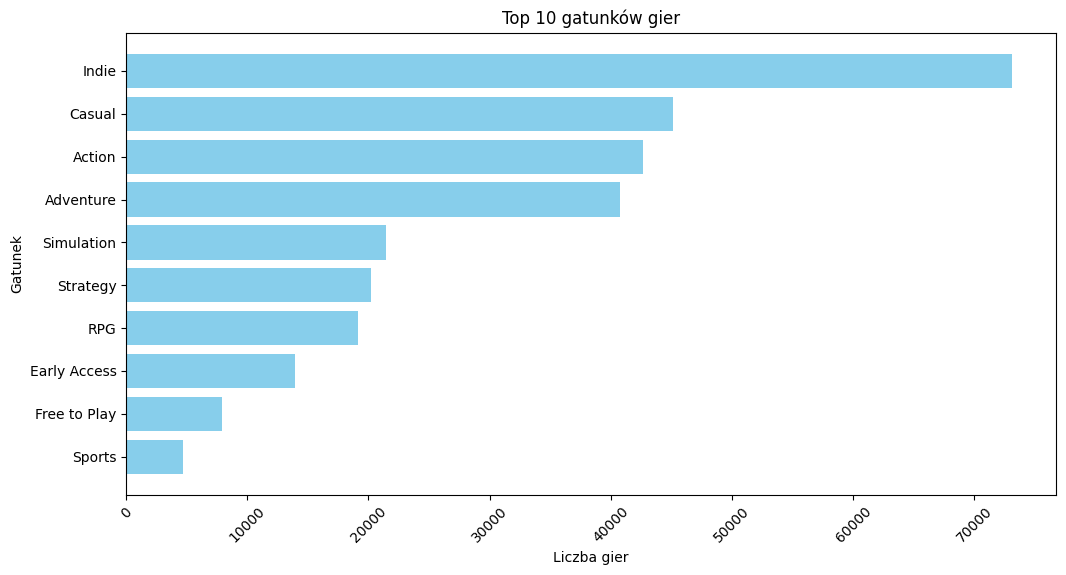

In [75]:
# Gatunki (top 10)
all_genres = [genre for sublist in df['genres'].dropna() for genre in sublist if sublist]
genre_counts = Counter(all_genres)
top_genres = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Number of Games'])
plt.figure(figsize=(12, 6))
plt.barh(top_genres['Genre'], top_genres['Number of Games'], color='skyblue')
plt.title('Top 10 gatunków gier')
plt.ylabel('Gatunek')
plt.xlabel('Liczba gier')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.show()

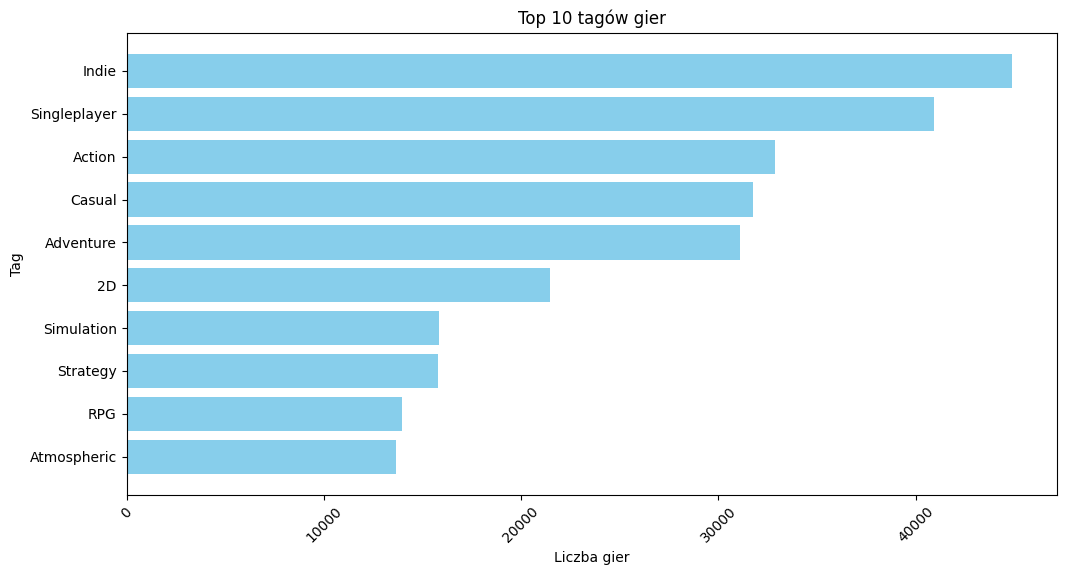

In [76]:
# Tagi (top 10)
all_tags = [tag.strip() for sublist in df['tags'].dropna() for tag in sublist.split(',') if sublist]
tag_counts = Counter(all_tags)
top_tags = pd.DataFrame(tag_counts.most_common(10), columns=['Tag', 'Number of Games'])
plt.figure(figsize=(12, 6))
plt.barh(top_tags['Tag'], top_tags['Number of Games'], color='skyblue')
plt.title('Top 10 tagów gier')
plt.ylabel('Tag')
plt.xlabel('Liczba gier')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.show()

Zmienne *positive* i *negative* reprezentują liczbę pozytywnych i negatywnych recenzji dla każdej gry, które mogą być przedstawione wspólnie. Możemy zauważyć, żew są ekstremalne wartości, które nie są błędami, ale z uwagi na popularność gry na platformie. Dodatkowo, 34% gier nie ma recenzji.

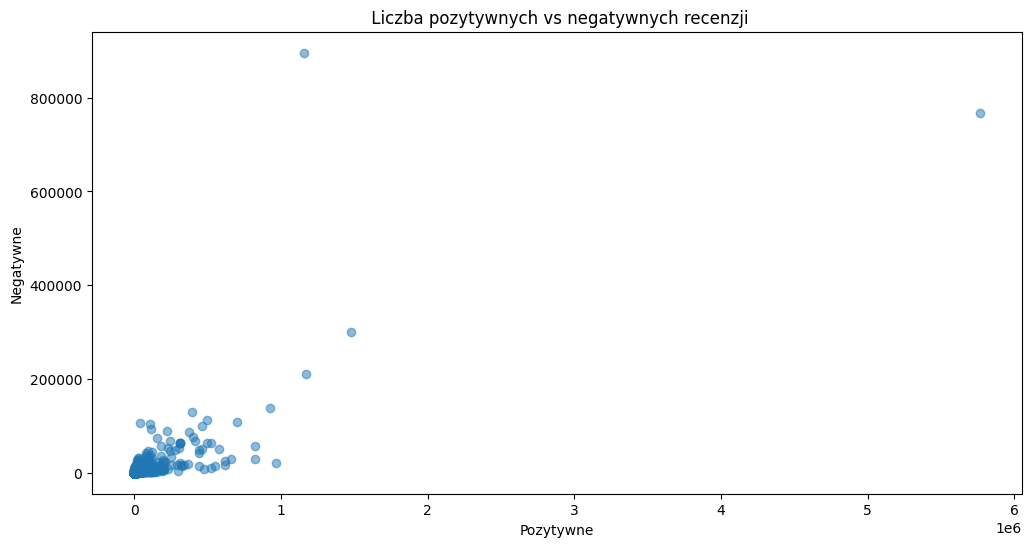

In [77]:
# Reviews
plt.figure(figsize=(12, 6))
plt.scatter(df['positive'], df['negative'], alpha=0.5)
plt.title(' Liczba pozytywnych vs negatywnych recenzji')
plt.xlabel('Pozytywne')
plt.ylabel('Negatywne')
plt.show()

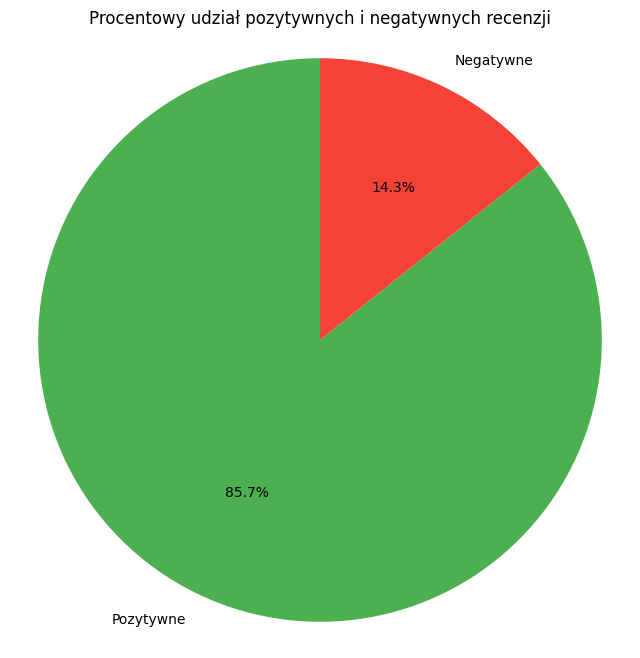

In [104]:
positive_sum = df['positive'].sum()
negative_sum = df['negative'].sum()


labels = ['Pozytywne', 'Negatywne']
sizes = [positive_sum, negative_sum]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
plt.title('Procentowy udział pozytywnych i negatywnych recenzji')
plt.axis('equal')
plt.show()

In [78]:
# Ponad 500000 negatywnych recenzji 
df[df['negative'] > 500000]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
8885,PUBG: BATTLEGROUNDS,2017-12-21,0.0,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,True,False,False,...,1154655,895978,50000000 - 100000000,21963,790,7134,275374,"Survival, Shooter, Multiplayer, Battle Royale,...",578080,NaN
46158,Counter-Strike: Global Offensive,2012-08-21,0.0,1,Counter-Strike: Global Offensive (CS: GO) expa...,Counter-Strike: Global Offensive (CS: GO) expa...,Counter-Strike: Global Offensive (CS: GO) expa...,True,True,True,...,5764420,766677,50000000 - 100000000,30484,777,6357,825215,"FPS, Shooter, Multiplayer, Competitive, Action...",730,NaN


Pomimo, że przedstawione wyżej gry mają ponad 500 tys niegatywnych recenzji, warto zwrócić uwagę na pozytywne, które idą w milionach. Jak widać poniżej, 34% gier nie posiada żadnych recenzji, wchodzą w to gry niszowe jak i takie, które na czas zbioru jeszcze nie wyszły. 

In [79]:
# Proporcja gier bez recenzji
round(df[(df['positive'] + df['negative']) == 0].shape[0] / df.shape[0], 2)

0.34

Zmienna *estimated_owners* zawiera estymację sprzedaży gry, skategoryzowaną według widełek. Większość gier wpada do pierwszej kategorii ze sprzedażą na poziomie 0-20tys jednostek.

<Axes: xlabel='estimated_owners'>

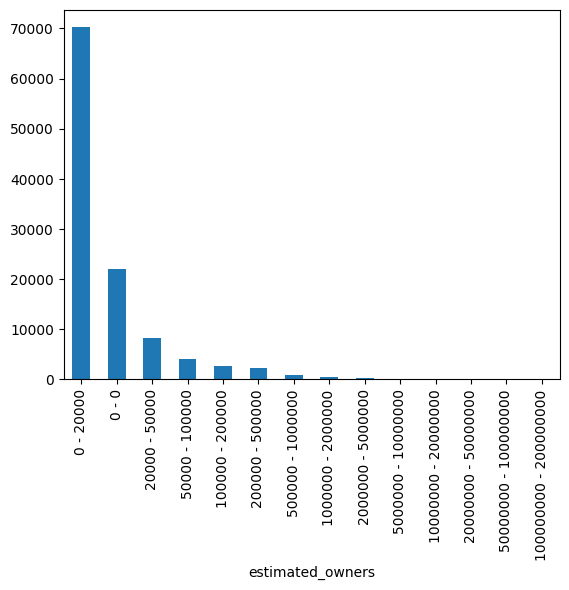

In [80]:
df['estimated_owners'].value_counts().plot(kind='bar')

In [81]:
# Gry z zerową ilością posiadaczy
df[df['estimated_owners'] == '0 - 0']

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,peak_ccu,tags,app_id,discount
53,Eternal Edge+ Prologue,2022-05-05,0.00,0,Buy/Wishlist the Full Version on Steam / Isle ...,Eternal Edge + Prologue is a casual Action Adv...,Eternal Edge + is a casual Action-Adventure ro...,True,False,False,...,0,0,0 - 0,0,0,0,0,,1959480,NaN
95,Moon Farming - Prologue,2022-01-06,0.00,0,Wishlist And Follow Full Game / / About the Ga...,/ / Tired from the same farming games on Earth...,Tired from the same farming games on Earth? No...,True,False,False,...,0,0,0 - 0,0,0,0,0,,1662060,NaN
105,溪风谷之战 Playtest,2022-03-24,0.00,0,,,,True,False,False,...,0,0,0 - 0,0,0,0,0,,1943590,NaN
106,Deer Journey,2022-07-21,5.39,0,Deer Journey is a third person walking simulat...,Deer Journey is a third person walking simulat...,Deer Journey is a third person walking simulat...,True,False,False,...,0,0,0 - 0,0,0,0,0,,1995240,NaN
180,Burial Stone Playtest,2022-04-13,0.00,0,,,,True,False,False,...,0,0,0 - 0,0,0,0,0,,1966960,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111434,Delusional Playtest,2025-04-11,0.00,0,,,,True,False,False,...,0,0,0 - 0,0,0,0,0,,3654520,0
111439,Forgery Craft Playtest,2025-02-27,0.00,0,,,,True,False,False,...,0,0,0 - 0,0,0,0,0,,3012940,0
111440,Cyber-ART,2025-03-25,0.00,0,Cyber-ART is a clicker game where your goal is...,Cyber-ART is a clicker game where your goal is...,"Cyber-ART is a clicker game. In the game, you ...",True,False,False,...,0,0,0 - 0,0,0,0,0,,3490740,0
111442,PlanetX,2025-04-18,0.00,0,PlanetX is a real-time strategy MMO that redef...,PlanetX is a real-time strategy MMO that redef...,PlanetX is a real-time strategy MMO set on a s...,True,True,False,...,0,0,0 - 0,0,0,0,0,,3309950,0


Zbiór danych zawiera również informacje o średnim czasie spędzonym w danej grze, jak również całkowitym czasie i czasie spędzonym w grze w ostatnich 2 tygodniach - mierzone w minutach. Możemy zobaczyć, że 86% gier ma czas grania 0 minut, co wskazuje brak danych. Ignorując te wiersze, dystrybucja się zmienia. Można zauważyć, że gry z danymi czasu grania są najpopularniejsze, mając 90 razy więcej komentarzy: 

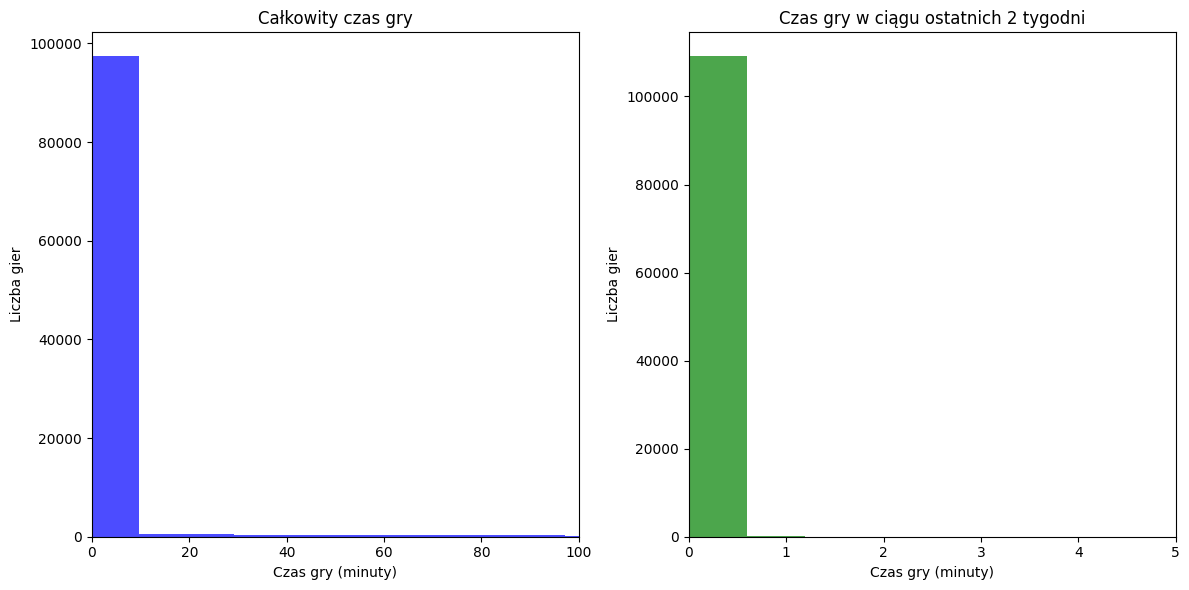

In [82]:
# Average playtime
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['average_playtime_forever'], bins=15000, color='blue', alpha=0.7)
plt.title('Całkowity czas gry')
plt.xlabel('Czas gry (minuty)')
plt.ylabel('Liczba gier')
plt.xlim(0, 100)
plt.subplot(1, 2, 2)
plt.hist(df['average_playtime_2weeks'], bins=32000, color='green', alpha=0.7)
plt.title('Czas gry w ciągu ostatnich 2 tygodni')
plt.xlabel('Czas gry (minuty)')
plt.ylabel('Liczba gier')
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

In [83]:
# Proporcja gier bez czasu w grze
proportion = df[df['average_playtime_forever'] == 0].shape[0] / df.shape[0]
round(proportion, 2)

0.86

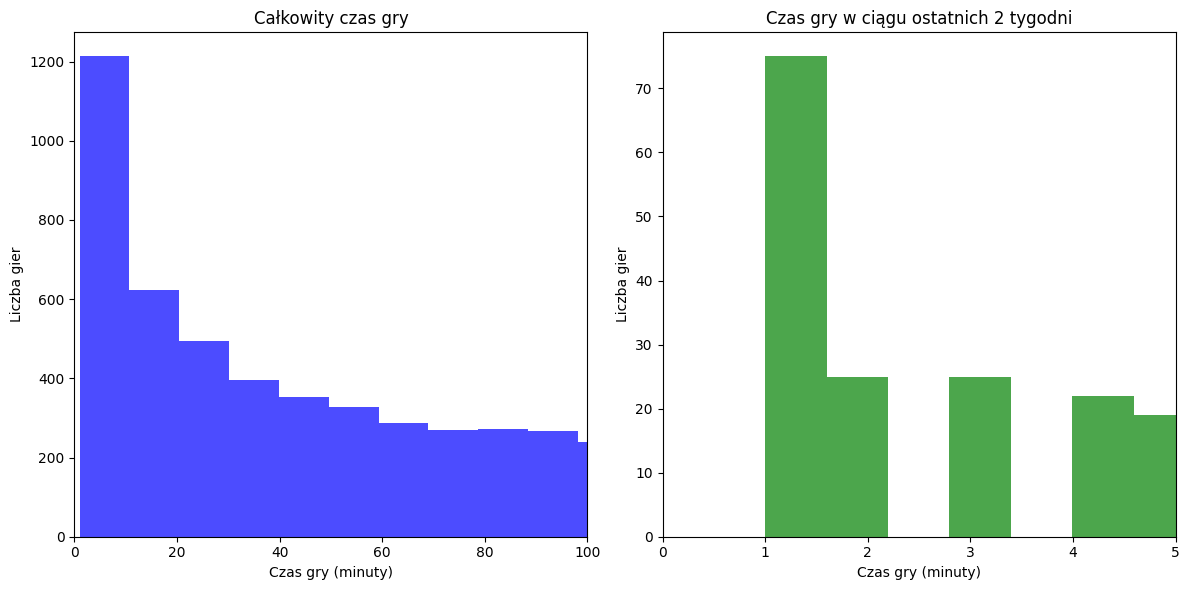

In [84]:
# Średni czas gry (usuwając 0)
filtered_df = df[df['average_playtime_forever'] != 0]
filtered_2weeks_df = df[df['average_playtime_2weeks'] != 0]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(filtered_df['average_playtime_forever'], bins=15000, color='blue', alpha=0.7)
plt.title('Całkowity czas gry')
plt.xlabel('Czas gry (minuty)')
plt.ylabel('Liczba gier')
plt.xlim(0, 100)
plt.subplot(1, 2, 2)
plt.hist(filtered_2weeks_df['average_playtime_2weeks'], bins=32000, color='green', alpha=0.7)
plt.title('Czas gry w ciągu ostatnich 2 tygodni')
plt.xlabel('Czas gry (minuty)')
plt.ylabel('Liczba gier')
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

In [85]:
# Liczba komentarzy gry czas gry == 0 vs. > 0
group_1 = df[df['average_playtime_forever'] == 0]
group_1_mean = (group_1['positive'] + group_1['negative']).mean()
group_2 = df[df['average_playtime_forever'] > 0]
group_2_mean = (group_2['positive'] + group_2['negative']).mean()
print(f"Number of reviews (playtime_forever == 0): {group_1_mean}")
print(f"Number of reviews (playtime_forever > 0): {group_2_mean}")

Number of reviews (playtime_forever == 0): 69.35437473369153
Number of reviews (playtime_forever > 0): 6003.537264429707


Sprawdźmy dane ceny po gatunkach. Cena jak można zauważyć różni się dwukrotnie pomiędzy "Massive multiplayer" i gatunkiem "Sports". A najwięcej wynosi za gatunek "Video Production", czyli programy do obróbki wideo.

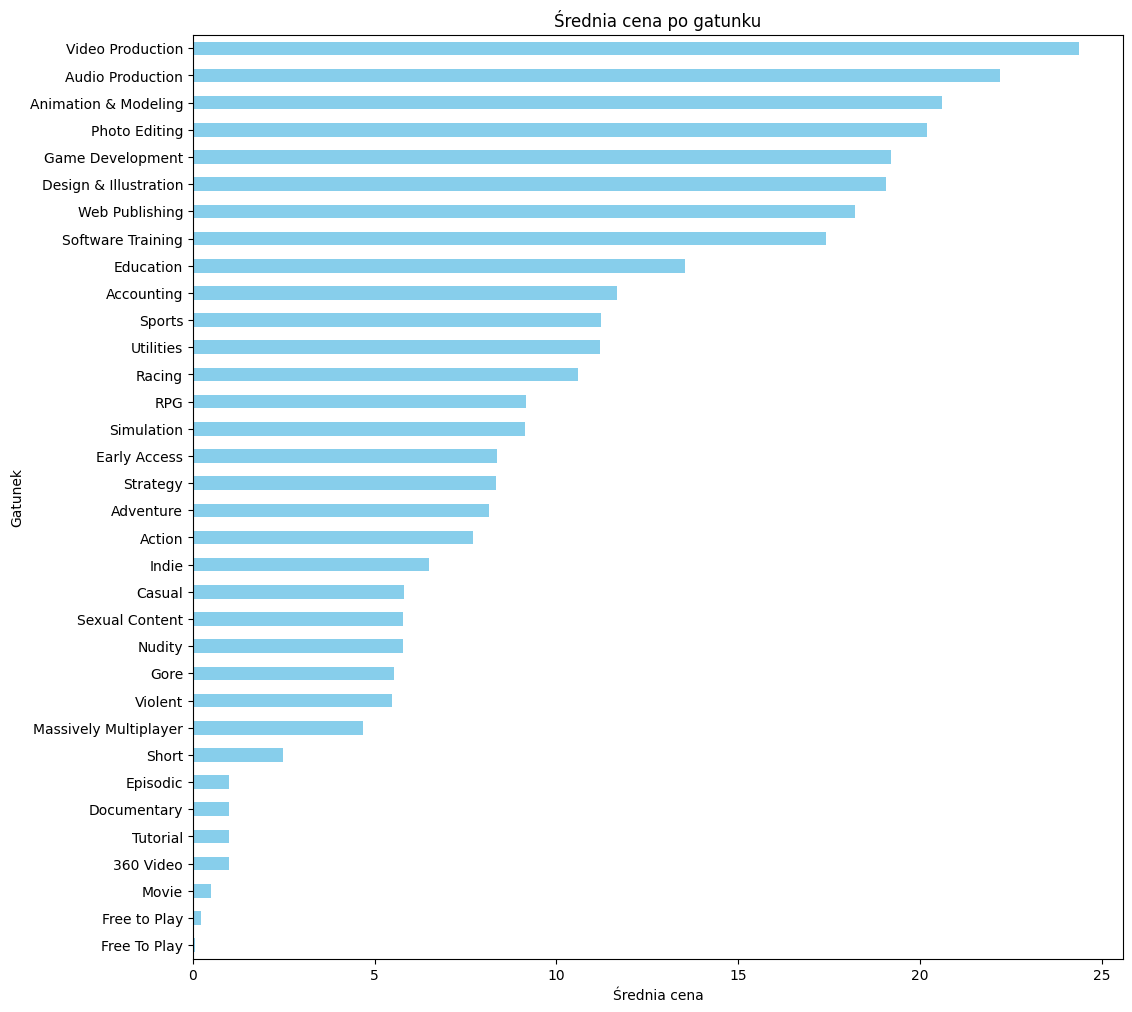

In [86]:
# Price by genre
exploded_df = df.explode('genres')
average_price_by_genre = exploded_df.groupby('genres')['price'].mean().sort_values()
plt.figure(figsize=(12, 12))
average_price_by_genre.plot(kind='barh', color='skyblue')
plt.title('Średnia cena po gatunku')
plt.xlabel('Średnia cena')
plt.ylabel('Gatunek')
plt.show()

Liczba dodatków również się znacznie różni w zależności od gatunku:

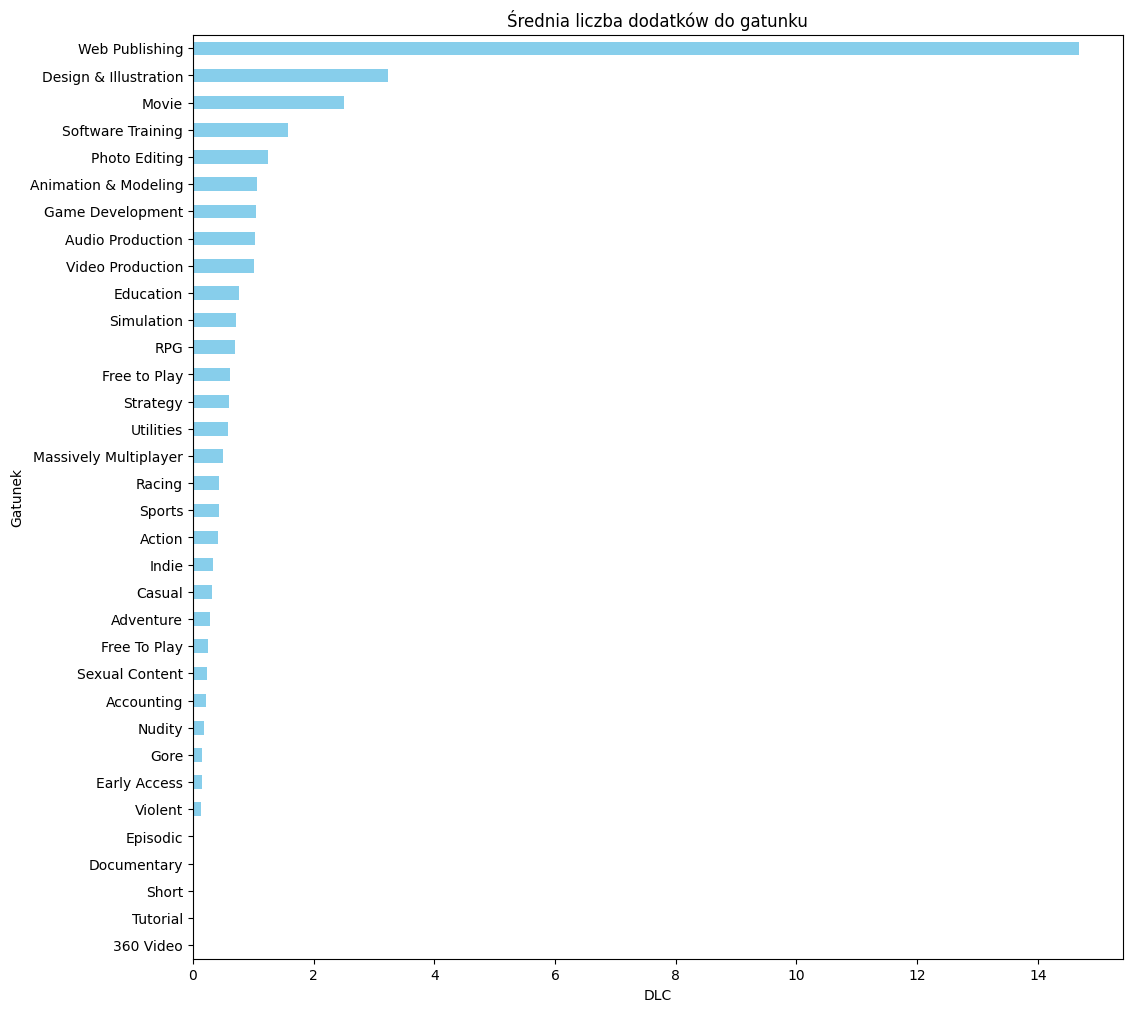

In [87]:
# DLC w zależności od gatunku
exploded_df = df.explode('genres')
average_dlc_count_by_genre = exploded_df.groupby('genres')['dlc_count'].mean().sort_values()
plt.figure(figsize=(12, 12))
average_dlc_count_by_genre.plot(kind='barh', color='skyblue')
plt.title('Średnia liczba dodatków do gatunku')
plt.xlabel('DLC')
plt.ylabel('Gatunek')
plt.show()

Opisy zawierające różne słowa w zależności od gatunku: Sports i RPG

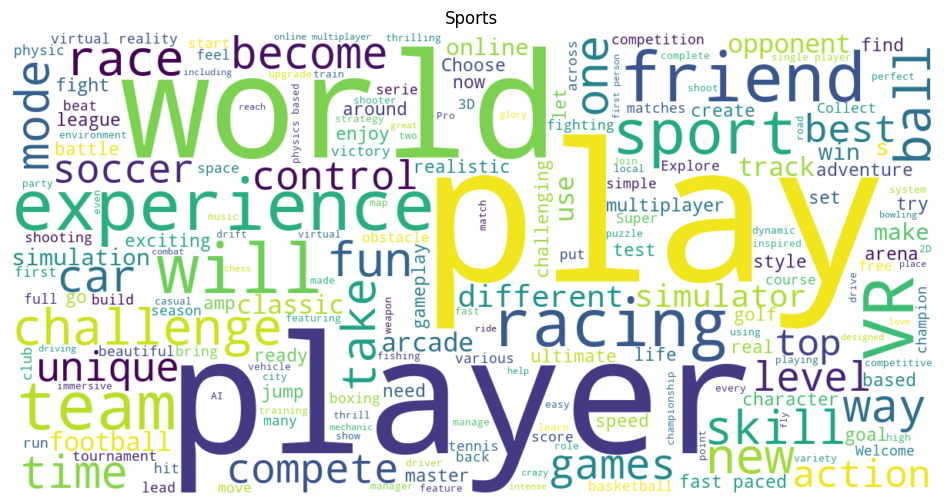

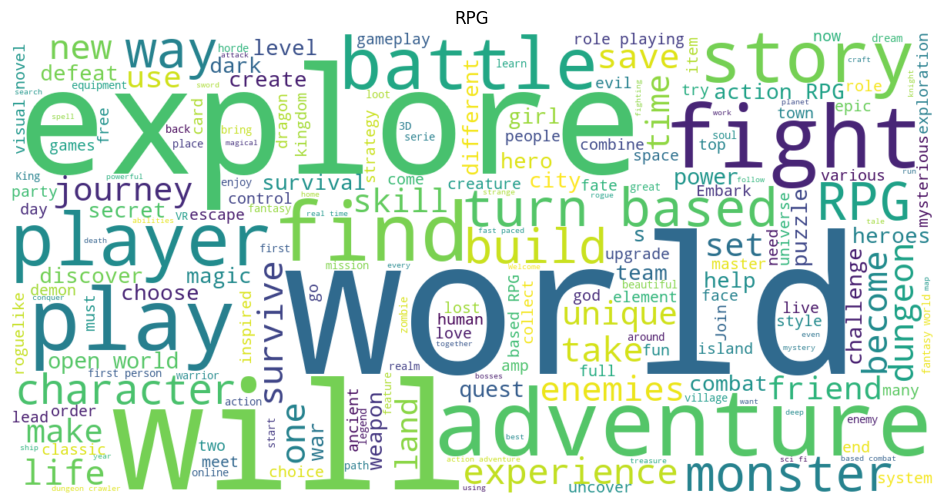

In [88]:
# Wordcloud by genres: Sports i RPG
exploded_df = df.explode('genres')
sports_df = exploded_df[exploded_df['genres'] == 'Sports']
rpg_df = exploded_df[exploded_df['genres'] == 'RPG']
sports_text = ' '.join(sports_df['short_description'].dropna())
rpg_text = ' '.join(rpg_df['short_description'].dropna())
def generate_wordcloud(text, title, additional_stopwords=None):
    stopwords = set(STOPWORDS)
    if additional_stopwords:
        stopwords = stopwords.union(additional_stopwords)
    wordcloud = WordCloud(width=1200, height=600, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
generate_wordcloud(sports_text, 'Sports', additional_stopwords={'game'})
generate_wordcloud(rpg_text, 'RPG', additional_stopwords={'game'})

I czas grania w zależności od gatunku w ostatnich 2 tygodniach

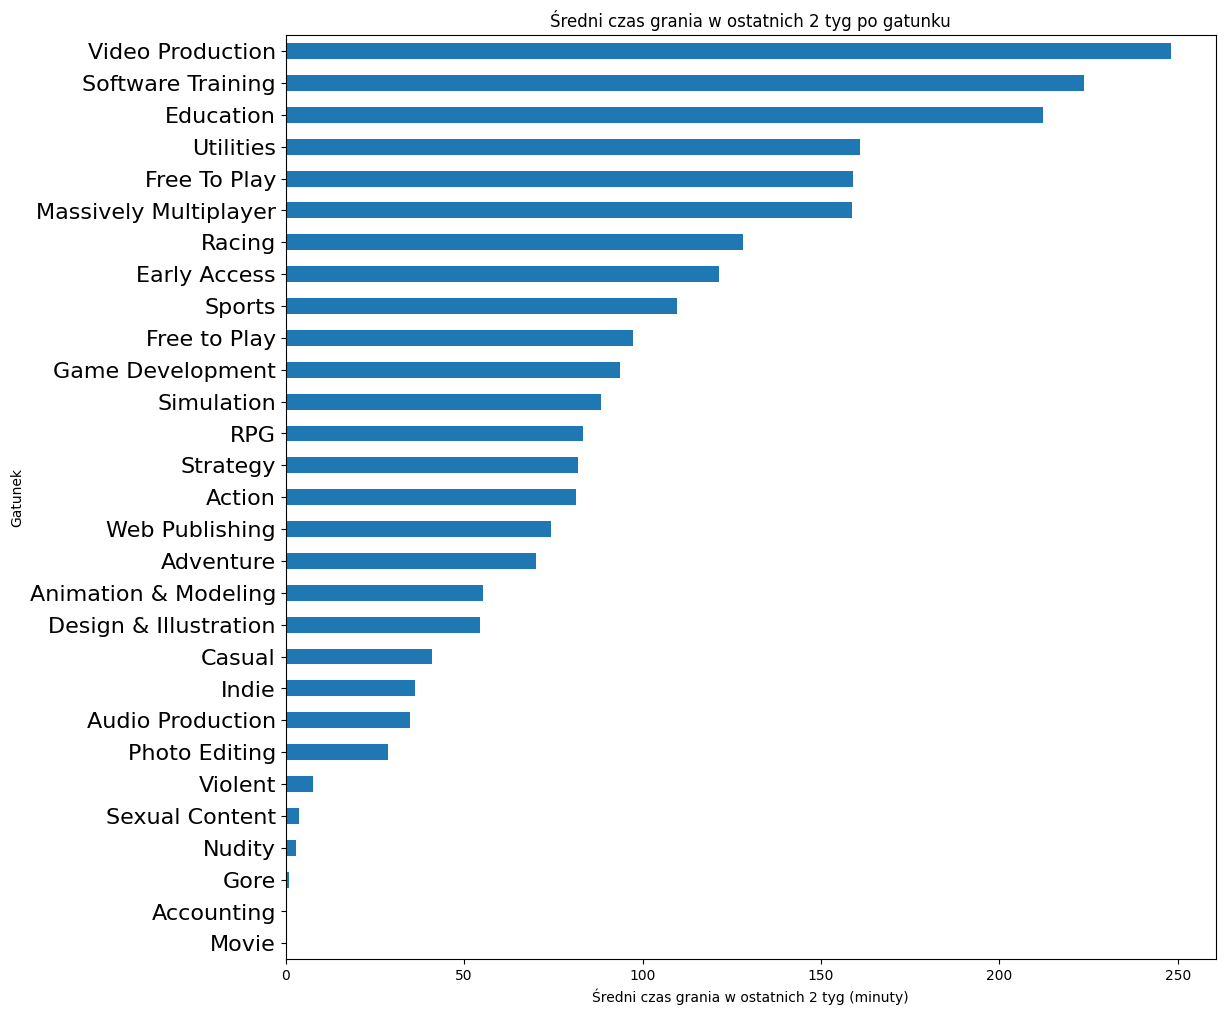

In [89]:
# Playtime by Genre
filtered_df = df[df['average_playtime_forever'] != 0]
df_expanded = filtered_df.explode('genres')
mean_playtimes = df_expanded.groupby('genres')['average_playtime_2weeks'].mean()
mean_playtimes_sorted = mean_playtimes.sort_values(ascending=False)
mean_playtimes_sorted.plot(kind='barh', figsize=(12, 12))
plt.title('Średni czas grania w ostatnich 2 tyg po gatunku')
plt.ylabel('Gatunek')
plt.xlabel('Średni czas grania w ostatnich 2 tyg (minuty)')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

## Number of games produced every year

Sprawdźmy teraz ile gier jest produkowanych co roku

In [90]:
df['Release date cleaned'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['Release date cleaned'].dt.year
years = df.groupby("year").agg({
    "name":"count"
}).reset_index()
years.sort_values("name",ascending = False)

,year,name
27,2024,20584
26,2023,15543
25,2022,13989
24,2021,12394
23,2020,9647
21,2018,8183
22,2019,7827
20,2017,6334
28,2025,6037
19,2016,4416


## Prognoza wydanych gier w kolejnych latach

Teraz spróbujemy zrobić prognozę jeśli chodzi o wydane gry na 3 kolejne lata. Użyjemy do tego regresji liniowej z pakietu scikit-learn. Żeby 2025, który dalej trwa, a dataframe posiadał dane tego roku, to zdecydowaliśmy się na pozbycie ich.

In [93]:
years = years[years['year'] != 2025]

In [94]:
years['year']

0     1997
1     1998
2     1999
3     2000
4     2001
5     2002
6     2003
7     2004
8     2005
9     2006
10    2007
11    2008
12    2009
13    2010
14    2011
15    2012
16    2013
17    2014
18    2015
19    2016
20    2017
21    2018
22    2019
23    2020
24    2021
25    2022
26    2023
27    2024
Name: year, dtype: int32

In [99]:
# Przygotuj dane do modelu
X = years['year'].values.reshape(-1, 1)
y = years['name'].values

# Tworzenie i trenowanie modelu
model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [100]:
future_years = np.array([[2025], [2026], [2027]])
predictions = model.predict(future_years)

# Dodaj prognozy do DataFrame
future_df = pd.DataFrame({'release_year': [2025, 2026, 2027], 'count': predictions.astype(int)})

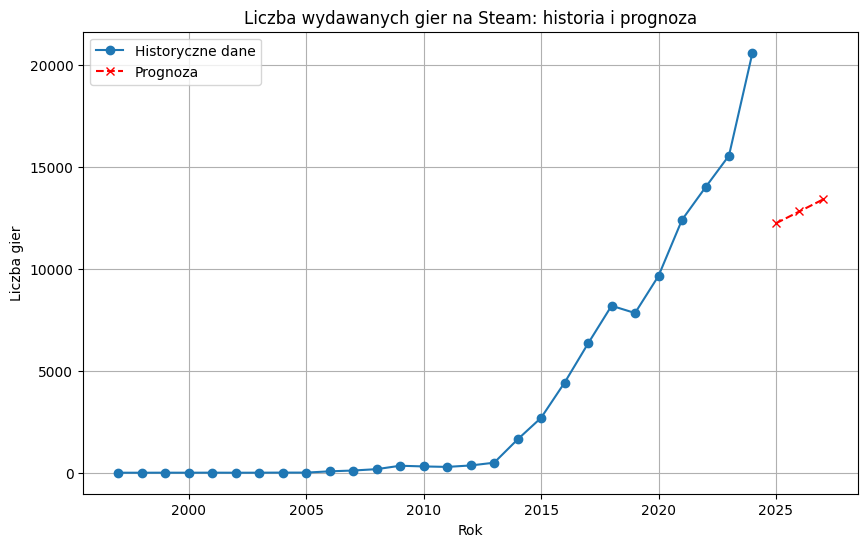

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(years['year'], years['name'], marker='o', label='Historyczne dane')
plt.plot(future_df['release_year'], future_df['count'], marker='x', linestyle='--', color='red', label='Prognoza')
plt.xlabel('Rok')
plt.ylabel('Liczba gier')
plt.title('Liczba wydawanych gier na Steam: historia i prognoza')
plt.legend()
plt.grid(True)
plt.show()

Jak możemy zauważyć, predykcja pokazuje, że ilość wydanych gier w 2025 będzie na poziomie około 12 tys pozycji z umiarkowanym wzrostem każdego roku.

## Game length

Sprawdźmy na podstawie innego zbioru długość gry na podstawie informacji ze strony "How Long to Beat", który różni się znacząco w zależności od gatunków:

In [102]:
current_dir = os.path.dirname(os.path.abspath(''))

second_file = os.path.join(current_dir, 'E:\Game_Analysis\input\steamdb.json')
df3 = pd.read_json(second_file)

<>:3: SyntaxWarning: invalid escape sequence '\G'
<>:3: SyntaxWarning: invalid escape sequence '\G'
C:\Users\krystian\AppData\Local\Temp\ipykernel_56748\3793406971.py:3: SyntaxWarning: invalid escape sequence '\G'
  second_file = os.path.join(current_dir, 'E:\Game_Analysis\input\steamdb.json')


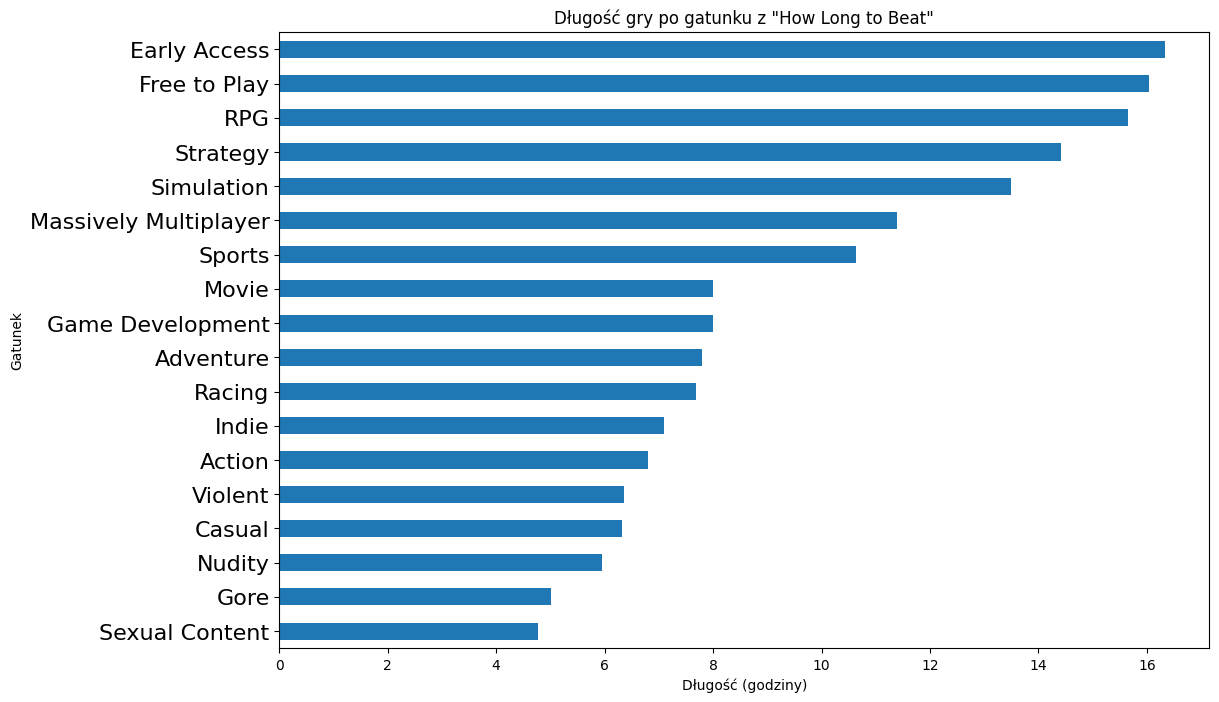

In [103]:
# Game duration by genre (HLTB)
filtered_df = df3[df3['hltb_single'].notna()].copy()
filtered_df['genres'] = filtered_df['genres'].str.split(',')
df_expanded = filtered_df.explode('genres')
average_times = df_expanded.groupby('genres')['hltb_single'].mean()
average_times_sorted = average_times.sort_values(ascending=False)
average_times_sorted.plot(kind='barh', figsize=(12, 8))
plt.title('Długość gry po gatunku z "How Long to Beat"')
plt.ylabel('Gatunek')
plt.xlabel('Długość (godziny)')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()